In [50]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ", device)


cuda


In [27]:
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor()
)

batch_size = 100
n_epochs = 20


In [28]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

# valid_loader = torch.utils.data.DataLoader(
#     dataset=valid_dataset, batch_size=batch_size, shuffle=False
# )

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)


# coRNN Model

In [29]:
class coRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, dt, gamma, epsilon):
        super().__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        self.i2h = nn.Linear(input_size + hidden_size + hidden_size, hidden_size)

    def forward(self, x, hy, hz):
        combined_layer = torch.cat((x, hz, hy), 1)
        hz = hz + self.dt * (
            torch.tanh(self.i2h(combined_layer)) - self.gamma * hy - self.epsilon * hz
        )
        hy = hy + self.dt * hz

        return hy, hz


class coRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt, gamma, epsilon):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = coRNNCell(input_size, hidden_size, dt, gamma, epsilon)
        self.readout = nn.Linear(hidden_size, output_size)

    def forward():
        hy = Variable(torch.zeros(batch_size, self.hidden_size))
        hz = Variable


# LSTM

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super().__init__()

        # ? Hidden layer dimentions
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # ? shape: (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

        # ? Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # ? x shape: (batch_size, seq_len, input_size)
        # ? h0 shape: (n_layers, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        c0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))

        h0, c0 = h0.to(device), c0.to(device)

        # ? out shape: (seq_len, batch_size, hidden_dim) => (64, 28, 100)
        # ? hn shape: (n_layers * num_directions, batch_size, hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out



In [46]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.2):
        super().__init__()

        # ? Hidden layer dimentions
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # ? shape: (batch, seq, feature)
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(device)

        out, hn = self.gru(x, h0)
        out = self.fc(out[:, -1, :])

        return out


In [32]:
input_dim = 28
hidden_dim = 100
output_dim = 10
n_layers = 3

seq_dim = 28


In [42]:
def train(model, train_loader, optimizer, criterion):
    model.train()

    total_loss = 0

    for data, target in train_loader:
        images, labels = Variable(data), Variable(target)
        images, labels = images.to(device), labels.to(device)

        images = images.view(-1, seq_dim, input_dim)

        # ? Forward pass
        # * outputs size = (100, 10)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # ? Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(train_loader)


def validate(model, valid_loader):
    correct = 0
    total = 0
    model.eval()

    for images, labels in valid_loader:
        images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        correct += (predicted.cpu() == labels.cpu()).sum()

    accuracy = 100 * correct / total
    
    return accuracy

def predict(model, image):
    model.eval()
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)

    return predicted


# Training LSTM

In [34]:
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)  
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [35]:
lstm_valid_accuracy = []
lstm_train_loss = []

for epoch in range(n_epochs):
    loss = train(lstm_model, train_loader, optimizer, criterion)
    lstm_train_loss.append(loss)

    accuracy = validate(lstm_model, test_loader)
    lstm_valid_accuracy.append(accuracy)

    print(f"epoch: {epoch+1}, training-loss: {loss}, validation-accuracy: {accuracy}")


Epoch: 0, training-loss: 2.3013115266958875, validation-accuracy: 11.350000381469727
Epoch: 1, training-loss: 2.2989475870132448, validation-accuracy: 11.350000381469727
Epoch: 2, training-loss: 2.0348194295167925, validation-accuracy: 34.88999938964844
Epoch: 3, training-loss: 0.9805474570890268, validation-accuracy: 78.44000244140625
Epoch: 4, training-loss: 0.4793452968945106, validation-accuracy: 88.97000122070312
Epoch: 5, training-loss: 0.266025371948878, validation-accuracy: 94.41000366210938
Epoch: 6, training-loss: 0.18216475713377198, validation-accuracy: 96.2300033569336
Epoch: 7, training-loss: 0.13911955958853164, validation-accuracy: 96.63999938964844
Epoch: 8, training-loss: 0.11743276687183728, validation-accuracy: 97.41999816894531
Epoch: 9, training-loss: 0.09946455820308377, validation-accuracy: 97.36000061035156
Epoch: 10, training-loss: 0.08752988466216872, validation-accuracy: 97.31999969482422
Epoch: 11, training-loss: 0.08109535409137607, validation-accuracy: 97

# Training GRU

In [47]:
gru_model = GRUModel(input_dim, hidden_dim, output_dim, n_layers)
gru_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(gru_model.parameters(), lr=learning_rate)  


In [48]:
gru_valid_accuracy = []
gru_train_loss = []

for epoch in range(n_epochs):
    loss = train(gru_model, train_loader, optimizer, criterion)
    gru_train_loss.append(loss)

    accuracy = validate(gru_model, test_loader)
    gru_valid_accuracy.append(accuracy)

    print(f"epoch: {epoch+1}, training-loss: {loss}, validation-accuracy: {accuracy}")


Epoch: 0, training-loss: 1.6613507726788521, validation-accuracy: 73.44999694824219
Epoch: 1, training-loss: 0.5151151708761851, validation-accuracy: 89.80000305175781
Epoch: 2, training-loss: 0.2471583192795515, validation-accuracy: 94.23999786376953
Epoch: 3, training-loss: 0.16029263036015132, validation-accuracy: 95.55999755859375
Epoch: 4, training-loss: 0.11858338850550354, validation-accuracy: 96.94999694824219
Epoch: 5, training-loss: 0.09673569488804787, validation-accuracy: 97.2699966430664
Epoch: 6, training-loss: 0.07817997099443649, validation-accuracy: 97.6500015258789
Epoch: 7, training-loss: 0.06922699101734907, validation-accuracy: 98.13999938964844
Epoch: 8, training-loss: 0.0602055165276397, validation-accuracy: 98.2300033569336
Epoch: 9, training-loss: 0.05293155768963819, validation-accuracy: 98.38999938964844
Epoch: 10, training-loss: 0.047583277669424814, validation-accuracy: 98.33999633789062
Epoch: 11, training-loss: 0.043682174507606156, validation-accuracy: 9

# Plots

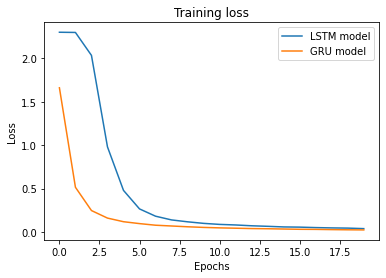

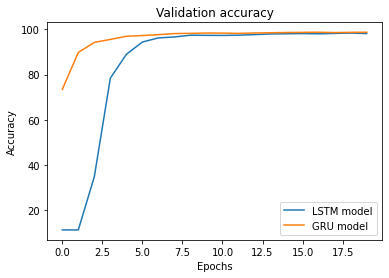

In [53]:
plt.plot(lstm_train_loss, label="LSTM model")
plt.plot(gru_train_loss, label="GRU model")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(lstm_valid_accuracy, label="LSTM model")
plt.plot(gru_valid_accuracy, label="GRU model")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
